In [12]:
import pyodbc
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np

In [14]:
import pyodbc
import pandas as pd
import os

# List of CSV files and their corresponding table names
csv_files = [
    ("customers.csv", "customers"),
    ("geolocation.csv", "geolocation"),
    ("order_items.csv", "order_items"),
    ("orders.csv", "orders"),
    ("payments.csv", "payments"),
    ("products.csv", "products"),
    ("sellers.csv", "sellers")
]

# Step 1: Connect to SQL Server
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=GUNJA\\SQLEXPRESS;'
    'DATABASE=e_commeres;'
    'Trusted_Connection=yes;'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = r"C:\Users\sumit\OneDrive\Documents\New folder\E-Commers"

# Function to map pandas dtypes to SQL Server types
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BIT'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'NVARCHAR(MAX)'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(file_path)

    # Convert columns that look like dates
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            try:
                df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=False)
            except Exception as e:
                print(f"Warning: Could not convert {col} to datetime - {e}")

    df = df.where(pd.notnull(df), None)  # Replace NaN with None
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    print(f"\nProcessing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Create table if it doesn't exist
    columns = ', '.join([f'[{col}] {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f"""
    IF OBJECT_ID(N'{table_name}', N'U') IS NULL
    BEGIN
        CREATE TABLE [{table_name}] ({columns})
    END
    """
    cursor.execute(create_table_query)

    # Insert data
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        placeholders = ', '.join(['?'] * len(row))
        sql = f"INSERT INTO [{table_name}] ({', '.join([f'[{col}]' for col in df.columns])}) VALUES ({placeholders})"
        cursor.execute(sql, values)

    conn.commit()

conn.close()



Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64


Processing geolocation.csv
NaN values before replacement:
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64



C:\Users\sumit\AppData\Local\Temp\ipykernel_53340\248649200.py:49: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=False)



Processing order_items.csv
NaN values before replacement:
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64



C:\Users\sumit\AppData\Local\Temp\ipykernel_53340\248649200.py:49: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=False)



Processing orders.csv
NaN values before replacement:
order_id                             0
customer_id                          0
order_status                         0
order_purchase_timestamp         59810
order_approved_at                  160
order_delivered_carrier_date     62109
order_delivered_customer_date    63087
order_estimated_delivery_date        0
dtype: int64


Processing payments.csv
NaN values before replacement:
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64


Processing products.csv
NaN values before replacement:
product_id                      0
product_category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64


Processing sellers.csv
NaN values before re

In [24]:

import pyodbc
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
# Create SQLAlchemy engine

engine = create_engine("mssql+pyodbc://GUNJA\\SQLEXPRESS/e_commeres?trusted_connection=yes&driver=SQL+Server")
conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=GUNJA\\SQLEXPRESS;'
    'DATABASE=e_commeres;'
    'Trusted_Connection=yes;'
)
cur = conn.cursor()

In [16]:
query=("""select distinct customer_city from customers""")


df = pd.read_sql_query(query, engine)

df

,customer_city
0,claudia
1,santa salete
2,sao jose dos cordeiros
3,santa izabel do oeste
4,andradina
...,...
4114,oriente
4115,taquaritinga do norte
4116,abaiara
4117,teixeiras


In [17]:
query = """ select distinct customer_city from customers """

df = pd.read_sql_query(query, engine)

df.head()

,customer_city
0,claudia
1,santa salete
2,sao jose dos cordeiros
3,santa izabel do oeste
4,andradina


In [18]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 68640)

In [19]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by upper(products.product_category)
"""

df = pd.read_sql_query(query,engine)
df

,category,sales
0,FASHION BAGS AND ACCESSORIES,26178993.6
1,MARKET PLACE,5440310.4
2,FOODS,5571440.4
3,PCS,33494586.0
4,TELEPHONY,58425846.0
...,...,...
69,FLOWERS,265561.2
70,MUSICAL INSTRUMENTS,27968894.4
71,HYGIENE DIAPERS,506550.0
72,SONG,828171.6


In [26]:
import pyodbc

conn = pyodbc.connect(
    'DRIVER={SQL Server};'
    'SERVER=GUNJA\\SQLEXPRESS;'
    'DATABASE=e_commeres;'
    'Trusted_Connection=yes;'
)

query = """
SELECT UPPER(products.product_category) AS Category, 
       ROUND(SUM(payments.payment_value), 2) AS Sales
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY UPPER(products.product_category)
"""

df = pd.read_sql_query(query,engine)


df


,Category,Sales
0,FASHION BAGS AND ACCESSORIES,26178993.6
1,MARKET PLACE,5440310.4
2,FOODS,5571440.4
3,PCS,33494586.0
4,TELEPHONY,58425846.0
...,...,...
69,FLOWERS,265561.2
70,MUSICAL INSTRUMENTS,27968894.4
71,HYGIENE DIAPERS,506550.0
72,SONG,828171.6


In [27]:
query = """ SELECT 
    CAST(SUM(CASE 
        WHEN payment_installments >= 1 THEN 1 
        ELSE 0 
    END) AS FLOAT) / COUNT(*) * 100 AS percentage
FROM payments"""
cur.execute(query)

data = cur.fetchall()
data
"the percentage of orders that were paid in installments is", data[0][0]


('the percentage of orders that were paid in installments is',
 99.99807481277554)

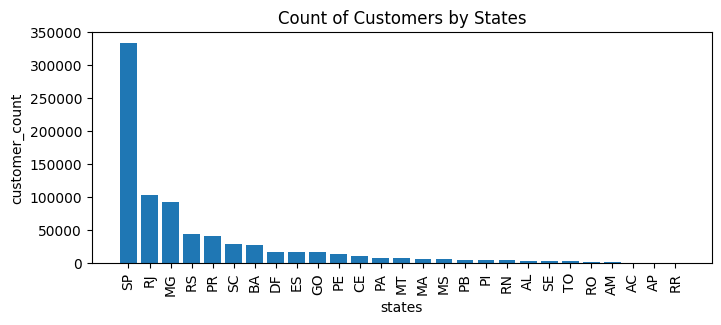

In [28]:
query = """ select customer_state ,count(customer_id) as customer_count
from customers group by customer_state
"""

df = pd.read_sql_query(query,engine)



df = df.sort_values(by = "customer_count", ascending= False)
plt.figure(figsize = (8,3))
plt.bar(df["customer_state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()


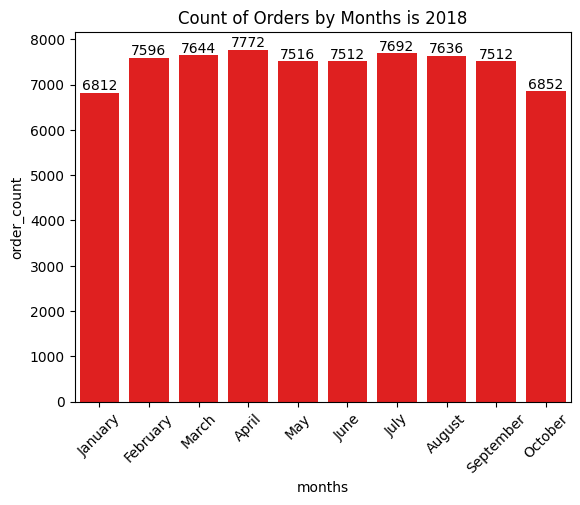

In [29]:
query = query="""SELECT 
    DATENAME(MONTH, order_purchase_timestamp) AS months,
    MONTH(order_purchase_timestamp) AS month_number,
    COUNT(order_id) AS order_count
FROM orders
WHERE 
    order_purchase_timestamp IS NOT NULL AND
    YEAR(order_purchase_timestamp) = 2018
GROUP BY 
    DATENAME(MONTH,order_purchase_timestamp),
    MONTH(order_purchase_timestamp)
ORDER BY 
    month_number"""

df = pd.read_sql_query(query,engine)
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

In [30]:

query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

df = pd.read_sql_query(query,engine)


df.head(10)
df



,customer_city,average_orders
0,padre carvalho,168
1,celso ramos,156
2,datas,144
3,candido godoi,144
4,matias olimpio,120
...,...,...
4105,cezarina,24
4106,abaete,24
4107,afonso claudio,24
4108,tabuleiro do norte,24


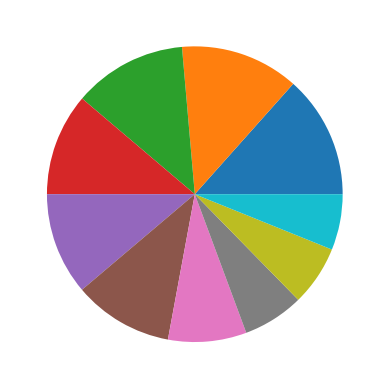

In [33]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by upper(products.product_category) order by sales_percentage desc"""


df = pd.read_sql_query(query,engine)


df2=df.head(10)
plt.pie(df2['sales_percentage'])
plt.show()

In [ ]:

query = """select products.product_category, 
count(order_items.product_id) as order_count,
round(avg(order_items.price),2) as price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

df = pd.read_sql_query(query,engine)


arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157566


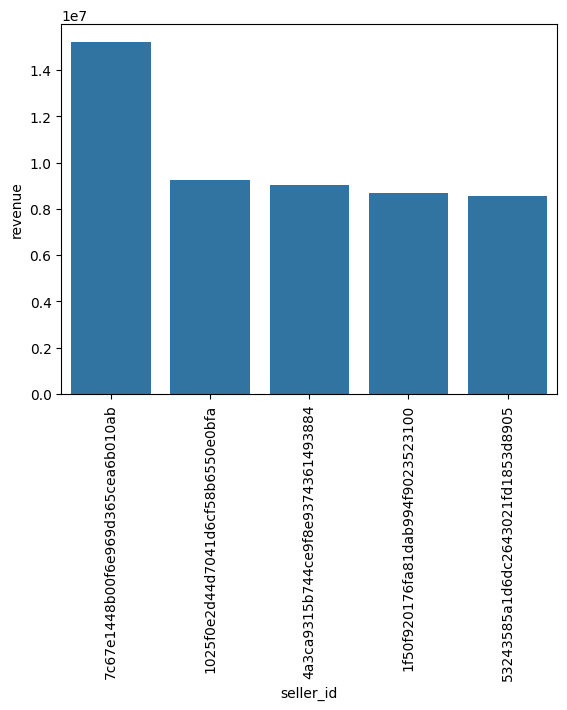

In [34]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """
df = pd.read_sql_query(query,engine)


df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

In [35]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
df = pd.read_sql_query(query,engine)
df

,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,NaT,114.74,114.74
1,00012a2ce6f8dcda20d059ce98491703,NaT,114.74,114.74
2,00012a2ce6f8dcda20d059ce98491703,NaT,114.74,114.74
3,00012a2ce6f8dcda20d059ce98491703,NaT,114.74,114.74
4,00012a2ce6f8dcda20d059ce98491703,NaT,114.74,114.74
...,...,...,...,...
2077715,ffffe8b65bbe3087b653a978c870db99,NaT,18.37,18.37
2077716,ffffe8b65bbe3087b653a978c870db99,NaT,18.37,18.37
2077717,ffffe8b65bbe3087b653a978c870db99,NaT,18.37,18.37
2077718,ffffe8b65bbe3087b653a978c870db99,NaT,18.37,18.37


In [39]:
query="""
 SELECT 
    years, 
    months, 
    payment, 
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        MONTH(orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments
        ON orders.order_id = payments.order_id 
    WHERE orders.order_purchase_timestamp IS NOT NULL
    GROUP BY 
        YEAR(orders.order_purchase_timestamp) , 
        MONTH(orders.order_purchase_timestamp)
) AS a
ORDER BY years, months;"""


df = pd.read_sql_query(query, engine)
df

,years,months,payment,cumulative_sales
0,2016,2,2186.8,2186.8
1,2016,3,11902.8,14089.6
2,2016,4,241017.6,255107.2
3,2016,5,205745.6,460852.8
4,2016,6,187972.2,648825.0
5,2016,7,165103.8,813928.8
6,2016,8,194322.6,1008251.4
7,2016,9,83042.2,1091293.6
8,2016,10,93502.0,1184795.6
9,2017,1,4983879.0,6168674.6


In [42]:
query="""
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments
        ON orders.order_id =payments.order_id 
    WHERE orders.order_purchase_timestamp IS NOT NULL
    GROUP BY YEAR(orders.order_purchase_timestamp)
)

SELECT 
    years, 
    ((payment - LAG(payment, 1) OVER (ORDER BY years)) /
     LAG(payment, 1) OVER (ORDER BY years)) * 100 AS growth_percent
FROM a
ORDER BY years"""

df = pd.read_sql_query(query, engine)
df


,years,growth_percent
0,2016,NaN
1,2017,4631.062877
2,2018,29.600183


In [43]:
query="""WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers 
    JOIN orders
        ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),

b AS (
    SELECT 
        a.customer_id, 
        COUNT(orders.order_purchase_timestamp) AS next_order
    FROM a 
    JOIN orders
        ON orders.customer_id = a.customer_id
        AND orders.order_purchase_timestamp > a.first_order
        AND orders.order_purchase_timestamp  < DATEADD(MONTH, 6, a.first_order)
    GROUP BY a.customer_id
)

SELECT 
    100.0 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id) AS repeat_rate_percentage
FROM a 
LEFT JOIN b 
    ON a.customer_id = b.customer_id"""
df = pd.read_sql_query(query, engine)
df

,repeat_rate_percentage
0,0.0


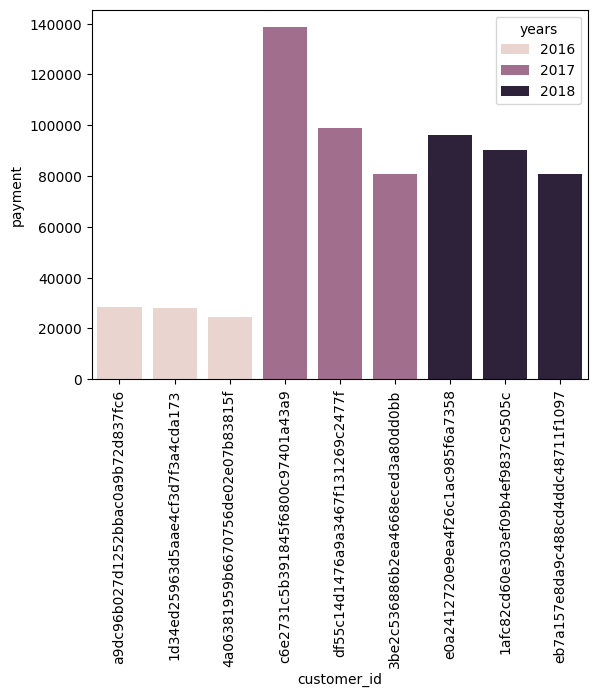

In [46]:
query="""SELECT 
    years, 
    customer_id, 
    payment, 
    d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM orders 
    JOIN payments 
        ON orders.order_id  = payments.order_id
    WHERE orders.order_purchase_timestamp IS NOT NULL
    GROUP BY 
        YEAR(orders.order_purchase_timestamp ), 
        orders.customer_id
) AS a
WHERE d_rank <= 3
ORDER BY years, d_rank;"""
df = pd.read_sql_query(query, engine)
df

sns.barplot(x = "customer_id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()


